In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Exercise 2: Hartree-Fock calculations of nuclei

In this exercise, we will develop all the ingredients needed for Hartree-Fock (HF) calculations of nuclei. For simplicity, we will restrict ourselves to relatively small basis sizes (realistic calculations use basis sizes > 2000) and we will only consider Hamiltonians with two-nucleon forces. The inclusion of three-nucleon forces will be handled in the next exercise.

We have a few learning objectives:

1. The construction of the starting harmonic oscillator (HO) single-particle basis and the selection of our starting occupied states.
2. The construction of the $A$-body Hamiltonian.
3. The evaluation of Hartree-Fock for a given Hamiltonian and system.
4. The investigation of the impact of our basis size and parameters on the final HF solution.

## The 3D harmonic oscillator as a starting point for nuclear structure

The standard choice for the starting point for calculations of nuclei are matrix elements in a harmonic oscillator basis. Specifically, we consider the eigenstates of the 3D harmonic oscillator

$$
H_\mathrm{HO} = \frac{p^2}{2m} + \frac{1}{2} m \omega r^2,
$$

which are

$$
|p \rangle = | n l m_l \rangle
$$

with energy eigenvalues $e_p = \hbar \omega (2 n + l + 3/2)$ (it is conventional to just ignore the final $+3/2$, which we also do from now on).

If we consider also spin and isospin degrees of freedom (which do not affect the HO energy), we get the states

$$
| n l m_l s m_s m_t\rangle.
$$

($s = 1/2.$ We use the convention that $m_t = 1/2$ for protons, $-1/2$ for neutrons. In other places this is sometimes reversed.) The states above can be coupled to states with good total angular momentum $j$, 

$$
|p \rangle = | n (l s) j m_j m_t\rangle = \sum_{m_l, m_s} C^{j m_j}_{l m_l s m_s} | n l m_l s m_s m_t\rangle
$$

using [Clebsch-Gordan coefficients](https://en.wikipedia.org/wiki/Clebsch%E2%80%93Gordan_coefficients).

**These will always be our starting single-particle states. All operators and other bases will be expanded in these HO states.**

For these exercises, we use the following object to create a single-particle state with specified quantum numbers:

In [2]:
from nptlshf.core import State

my_state = State(n=0, l=0, jj=1, mm=-1, tt=1)

print(f"n = {my_state.n}")
print(f"l = {my_state.l}")
print(f"j = {my_state.jj} / 2")
print(f"m_j = {my_state.mm} / 2")
print(f"m_t = {my_state.tt} / 2")
print(f"My state is {my_state}")

n = 0
l = 0
j = 1 / 2
m_j = -1 / 2
m_t = 1 / 2
My state is | n =  0, l =  0, j =  1/2, tz =  1/2, m =  -1/2 >


> *Something to think about:* What makes these HO states more convenient for nuclei than for example a basis of plane-wave states $| \vec{k} m_s m_t \rangle$?

**Note:** we use a programming convention that half-integer numbers like our total angular momentum $j$ and our isospin $m_t$ are stored as "doubled" integers: $jj = 2 * j$. This allows us to use integers everywhere rather than converting between integers and floating point numbers, but we have to be careful to maintain this convention. Consider for example what happens when you want to loop over all allowed `mm` from `-1 * jj` to `jj` ($-j\leq m \leq j$). How big does the step size have to be?

The HO basis is infinite, so we must truncate it in some way. We will truncate it based on the HO energy $e_p$, including all states with $e_p \leq e_\mathrm{max}$.

### Problem 1: Write a function to generate all the states with $e_p \leq e_\mathrm{max}$. Have the function return a list of `State`s.

In [3]:
def generate_emax_basis(emax):
    '''
    Generate a basis of HO states up to truncation emax.

    Args:
        emax: maximum value of HO energy quantum number e = 2 * n + l allowed in basis.

    Returns:
        basis: List of State objects with appropriate quantum numbers.
    '''
    basis = []

    # TODO: Your code here
    for e in range(emax + 1):
        for n in range(0, emax // 2 + 1):
            l = e - 2 * n
            for jj in [2 * l - 1, 2 * l + 1]:
                if jj < 0:
                    continue
                for tt in [-1, 1]:
                    for mm in range(-1 * jj, jj + 1, 2):
                        basis.append(State(n, l, jj, mm, tt))

    return basis

In [4]:
# Code to check basis here.
from nptlshf.checks import check_problem_2_1
assert check_problem_2_1(generate_emax_basis)

# Check the size of your basis for emax=0, 2, and 4.

print(len(generate_emax_basis(5)))

224


> *Something to think about:* Does the order of states in the basis matter?

**Important: For the following exercises, use $e_\mathrm{max} \leq 4$. This includes 140 states, meaning that two-body matrix elements $V_{pqrs}$ will require $140^4 * 8 \sim 3.07 \times 10^9\:\mathrm{bytes} \sim 3\:\mathrm{GB}$ of storage. This is at the limit for most laptops currently.**

We now need to set the occupied orbitals for our system of interest. We start by considering $^4\mathrm{He}$ consisting of 2 neutrons and 2 protons. Recall [the Bohr-Mottelson ordering of orbitals](https://en.wikipedia.org/wiki/Nuclear_shell_model):

![Bohr-Mottelson ordering of orbitals](Exercise_2_figures/Shells.png "Bohr-Mottelson ordering of orbitals")

Defining the occupied orbitals gives us our occupation numbers:

$$
n_p = 
\begin{cases}
1 & \text{if\:|p\rangle\:occupied,} \\
0 & \mathrm{otherwise.} \\
\end{cases}
$$

### Problem 2: Write a function to generate the occupation numbers for $^4\mathrm{He}$ based on your basis. Have the function return a list of integers.

In [5]:
def generate_he4_occupation_numbers_from_basis(basis):
    '''
    Generate He4 occupation numbers from basis.

    Args:
        basis: List of HO State objects that is the single-particle basis.

    Returns:
        occupation_numbers: List of integers, where occupation_numbers[i] is 1 if basis[i] is occupied, 0 otherwise.
    '''
    
    occupation_numbers = []
    
    # TODO: Your code here
    occupation_numbers = [0] * len(basis)
    for i, state in enumerate(basis):
        if state.n == 0 and state.l == 0:
            occupation_numbers[i] = 1

    return occupation_numbers

In [6]:
# Code to check occupation numbers
from nptlshf.checks import check_problem_2_2
assert check_problem_2_2(generate_he4_occupation_numbers_from_basis)

# Maybe write some code to check that the occupations are as you expect for emax=2

## Constructing many-body Hamiltonians

Now we need to construct the Hamiltonian for our system. In principle, this is very simple; the general form is simply:

$$
H = T + V_{NN} (+ V_{3N}).
$$

For now we ignore the dependence on $V_{3N}$.

There is, however, another subtlety in the kinetic energy $T$. $T$ is the total kinetic energy of the system, including any kinetic energy related to momentum of the center-of-mass (CM) $P_\mathrm{CM}$. The binding energy of the system is the *intrinsic* energy, independent of any center-of-mass kinetic energy, so we want to be sure that we do not include the center-of-mass kinetic energy. For this, we have two options:

1. We consider a basis where $P_\mathrm{CM} = 0$.
2. We subtract the CM kinetic energy from the total kinetic energy to get the intrinsic kinetic energy $T_\mathrm{int} = T - T_\mathrm{CM}$.

For our basis, we cannot generally enforce $P_\mathrm{CM} = 0$ (*Question: How would one actually do this for a 3-particle state for example?*), so we choose option 2. This gives our Hamiltonian the general form:

$$
H = T - T_\mathrm{CM} + V_{NN} (+ V_{3N})
$$

with

$$
\begin{align}
T &= \sum_{i} \frac{\vec{p}_i^2}{2 m_N}, \\
T_\mathrm{CM} &= \frac{1}{A} \sum_{i} \frac{\vec{p}_i^2}{2 m_N} + \frac{1}{A} \sum_{i \neq j} \frac{\vec{p}_i \cdot \vec{p}_j}{2 m_N} \\
&= \frac{1}{A} T + \frac{1}{A} \sum_{i \neq j} \frac{\vec{p}_i \cdot \vec{p}_j}{2 m_N}.
\end{align}
$$

Note that $T_\mathrm{CM}$ depends on our system of interest through the total mass $A$ and has both 1- and 2-body parts, while $T$ is system independent and only has a 1-body part.

We provide functions to get the following matrix elements given your basis and a given value of $\hbar \omega$ ($\hbar \omega \in \{10, 12, 14, \dots , 40\:\mathrm{MeV}$):

$$
\begin{align}
T_{pq} &\leftrightarrow \sum_{i} \frac{\vec{p}_i^2}{2 m_N}, \\
T_\mathrm{CM,pqrs}^{\mathrm{(2B)}} &\leftrightarrow \sum_{i \neq j} \frac{\vec{p}_i \cdot \vec{p}_j}{2 m_N}, \\
V_{NN, pqrs} &\leftrightarrow \frac{1}{2} \sum_{i \neq j} V_{ij}.
\end{align}
$$

Note that $T_\mathrm{CM,pqrs}^{\mathrm{(2B)}}$ does **not** contain the factor of $1/A$.

These functions are called as follows:

In [7]:
# Sample code demonstrating functions with emax=2 basis and hw=16.
basis = generate_emax_basis(emax=2)
hw = 16

# These are your helper functions
from nptlshf.helpers import load_vnn, load_t, load_tcm_2b

# This function loads T_pq
t = load_t(basis, hw)

# This function loads T_CM,pqrs^2B
tcm_2b = load_tcm_2b(basis, hw)

# This function loads V_NN,pqrs
vnn = load_vnn(basis, hw)

print(t.shape)
print(tcm_2b.shape)
print(vnn.shape)

(40, 40)
(40, 40, 40, 40)
(40, 40, 40, 40)


### Problem 3: Write a function to construct the many-body Hamiltonian for $^4\mathrm{He}$ based on your basis and selected frequency $\hbar \omega$. Have the function return two arrays, one for the 1-body part and one for the two-body part.

In [8]:
def get_intrinsic_hamiltonian_for_he4_from_basis_and_hw(basis, hw):
    '''
    Compute the intrinsic for He4 based on your basis and hw.

    Args:
        basis: List of HO State objects that is the single-particle basis.
        hw: Integer in [10, 12, ... , 40] MeV for the oscillator frequency.

    Returns:
        h1: 1-body part of Hamiltonian with kinetic energy.
        h2: 2-body part of Hamiltonian with V_NN and 2-body kinetic energy correction.
    '''
    dim = len(basis)

    h_1b = np.zeros((dim, dim))
    h_2b = np.zeros((dim, dim, dim, dim))

    # Your code here
    A = 4
    
    t = load_t(basis, hw)
    tcm_2b = load_tcm_2b(basis, hw)
    vnn = load_vnn(basis, hw)

    h_1b = (1 - 1/A) * t
    h_2b = vnn - 1/A * tcm_2b

    return h_1b, h_2b

In [9]:
# Code to check Hamiltonian for hw=16, emax=2.
from nptlshf.checks import check_problem_2_3
assert check_problem_2_3(get_intrinsic_hamiltonian_for_he4_from_basis_and_hw)

# You can print your values for h_1b and h_2b for hw=16, emax=2 here.
# Most matrix elements will be 0.

Given our Hamiltonian and our occupation numbers, we can start by constructing our HO 1-body density matrix and evaluating the energy expectation value of our HO many-body state. Recall the expression to construct the density matrix:

$$
\rho_{pq} = \sum_{\bar{p}} C_{\bar{p}p} n_{\bar{p}} C_{\bar{p}q}^{*}
$$

where $C_{\bar{p}p}$ are the expansion coefficients of our "new" basis in the HO basis. What should $C_{\bar{p}p}$ be in this case?

We evaluate the energy expectation value for a state based on the density matrix using the expression:

$$
E = \sum_{pq} \rho_{pq} H_{pq}^{\mathrm{(1B)}} + \frac{1}{2} \sum_{pqrs} \rho_{pq} \rho_{rs} H_{prqs}^\mathrm{(2B)}
$$

### Problem 4: Write a function to compute a density matrix given occupation numbers and transformation coefficients.

### Problem 5: Write a function to compute the state energy expectation value given a density matrix and a 1- and 2-body Hamiltonian.

In [10]:
def construct_new_density(coeffs, occupation_numbers):
    '''
    Constructs 1-body density matrix.

    Args:
        coeffs: Matrix of coefficients from the starting basis to the new basis.
        occupation_numbers: List of occupation numbers for single-particle states in the new basis.
        
    Returns:
        density: 1-body density matrix representing the many-body state in the starting basis.
    '''
    dim = len(occupation_numbers)
    assert coeffs.shape == (dim, dim)
    density = np.zeros((dim, dim))

    density = coeffs.T @ np.diag(occupation_numbers) @ coeffs

    return density

In [11]:
def evaluate_1and2body_energy_from_density(h1, h2, density):
    '''
    Evaluates energy expectation value of state.

    Args:
        h1: 1-body matrix elements of Hamiltonian.
        h2: 2-body matrix elements of Hamiltonian.
        density: Density matrix of state.

    Returns:
        energy: Energy expectation value of state.
    '''
    energy = 0.0

    rho = density

    energy += np.einsum("ij,ij", rho, h1)
    energy += 0.5 * np.einsum("ij,kl,ikjl", rho, rho, h2)

    return energy

In [12]:
# Code to check functions above.
basis = generate_emax_basis(emax=2)
occs = generate_he4_occupation_numbers_from_basis(basis)
h1, h2 = get_intrinsic_hamiltonian_for_he4_from_basis_and_hw(basis, hw=16)
coeffs = np.identity(len(basis))
rho = construct_new_density(coeffs, occs)
e_ho = evaluate_1and2body_energy_from_density(h1, h2, rho)
print("E_HO = " + str(e_ho))
assert abs(e_ho - (-20.08023)) < 1e-5

E_HO = -20.08023


### Problem 6: Compute the HO energy of $^{4}\mathrm{He}$ for a range of $\hbar \omega$ values. Which $\hbar \omega$ gives the minimum energy?

In [13]:
def compute_ho_energies_he4(emax, hw_vals):
    '''
    Computes HO energies for various hw values given truncation emax.

    Args:
        emax: Basis truncation.
        hw: List of hw values.

    Returns:
        energies: List of energies corresponding to HO state expectation value at hw values.
    '''

    # TODO: Your code here
    
    basis = generate_emax_basis(emax)
    occs = generate_he4_occupation_numbers_from_basis(basis)
    coeffs = np.identity(len(basis))
    rho = construct_new_density(coeffs, occs)

    energies = []
    for hw in hw_vals:
        h1, h2 = get_intrinsic_hamiltonian_for_he4_from_basis_and_hw(basis, hw)
    
        e_ho = evaluate_1and2body_energy_from_density(h1, h2, rho)

        energies.append(e_ho)

    return energies

hw_vals = list(range(10, 41, 2))
energies = compute_ho_energies_he4(emax=2, hw_vals=hw_vals)

for hw, e_ho in zip(hw_vals, energies):
    print(f"hw = {hw} -> E_HO = {e_ho}")

hw = 10 -> E_HO = -12.033559999999994
hw = 12 -> E_HO = -15.137999999999998
hw = 14 -> E_HO = -17.84487
hw = 16 -> E_HO = -20.08023
hw = 18 -> E_HO = -21.803890000000003
hw = 20 -> E_HO = -22.99768999999999
hw = 22 -> E_HO = -23.660439999999994
hw = 24 -> E_HO = -23.80201000000001
hw = 26 -> E_HO = -23.43898
hw = 28 -> E_HO = -22.593100000000007
hw = 30 -> E_HO = -21.28930000000001
hw = 32 -> E_HO = -19.552899999999994
hw = 34 -> E_HO = -17.411200000000008
hw = 36 -> E_HO = -14.890500000000003
hw = 38 -> E_HO = -12.01639999999999
hw = 40 -> E_HO = -8.813199999999995


Now we want to solve the Hartree-Fock equations to get a better basis $| \bar{p} \rangle$ than our HO basis.

### Problem 7: Write a function to compute the Fock matrix $F$ given a density matrix and a 1- and 2-body Hamiltonian.

In [14]:
def compute_fock_matrix_from_density(h1, h2, density):
    '''
    Computes Fock matrix from a given density.

    Args:
        h1: 1-body Hamiltonian matrix elements.
        h2: 2-body Hamiltonian matrix elements.
        density: 1-body density matrix.

    Returns:
        f: Fock matrix.
    '''
    f = np.zeros_like(h1)

    f = np.einsum("ikjl,kl->ij", h2, density) + h1

    return f

In [15]:
# Code to check function.
# For emax=2, hw=16, write code to build the first Fock matrix. Check that it has off diagonal matrix elements.
basis = generate_emax_basis(emax=2)
occs = generate_he4_occupation_numbers_from_basis(basis)
h1, h2 = get_intrinsic_hamiltonian_for_he4_from_basis_and_hw(basis, hw=16)
coeffs = np.identity(len(basis))
rho = construct_new_density(coeffs, occs)
f = compute_fock_matrix_from_density(h1, h2, rho)
print(f)

[[-19.42818    0.         0.       ...   0.         0.         0.      ]
 [  0.       -19.42818    0.       ...  -3.323646   0.         0.      ]
 [  0.         0.       -18.65205  ...   0.        -3.156106   0.      ]
 ...
 [  0.        -3.323646   0.       ...   9.079356   0.         0.      ]
 [  0.         0.        -3.156106 ...   0.        10.14307    0.      ]
 [  0.         0.         0.       ...   0.         0.        10.14307 ]]


### Problem 8: Write a function to solve the Hartree-Fock equations for given occupation numbers and a 1- and 2-body Hamiltonian. Have the function return the HF energy, the HF density matrix, and the final expansion coefficients for the HF basis.

Optionally include parameters to limit the maximum number of iterations and the tolerance on the precision.

In [16]:
def diagonalize_fock_matrix(f):
    '''
    Diagonalizes the Fock matrix and returns the transformation coefficients C_{ibar, i}.$

    Args:
        f: Fock matrix.

    Returns:
        coeffs: Matrix of expansion coefficients of new basis in terms of starting basis. Specifically,
            coeffs[ibar, :] should be the full eigenvector corresponding to the new state |ibar> = sum_i C_{ibar, i} |i>.
    '''
    coeffs = np.zeros_like(f)

    _, coeffs = scipy.linalg.eigh(f)

    # Scipy returns our coefficients in a different format (with eigenvectors as columns, not rows).
    coeffs = coeffs.T

    return coeffs


def solve_hartree_fock_iteratively(h1, h2, occupation_numbers, verbose=True):
    '''
    Solve the Hartree-Fock equations for a given Hamiltonian and occupation numbers.

    Args:
        h1: 1-body matrix elements of Hamiltonian.
        h2: 2-body matrix elements of Hamiltonian.
        occupation_numbers: List of occupation numbers.

    Returns:
        e: HF energy.
        density: HF density matrix.
        coeffs: HF basis coefficients.
        n_iters: Number of iterations required to reach convergence.
    '''
    dim = len(occupation_numbers)
    assert h1.shape == (dim, dim)
    assert h2.shape == (dim, dim, dim, dim)

    e = 0.0
    rho = np.zeros((dim, dim))
    coeffs = np.zeros((dim, dim))
    n_iters = 0

    # My solution
    max_iters = 500
    energy_convergence_criterion = 1e-4

    occs = occupation_numbers

    coeffs = np.identity(dim)
    rho = construct_new_density(coeffs, occs)
    e_prev = evaluate_1and2body_energy_from_density(h1, h2, rho)

    for i in range(max_iters):

        f = compute_fock_matrix_from_density(h1, h2, rho)
        coeffs = diagonalize_fock_matrix(f)
        rho = construct_new_density(coeffs, occs)

        e = evaluate_1and2body_energy_from_density(h1, h2, rho)

        if abs(e - e_prev) < energy_convergence_criterion:
            break
        else:
            if verbose:
                print(f"HF iter {n_iters}: E_{n_iters} = {e_prev} -> E_{n_iters + 1} = {e}")
            n_iters += 1
            e_prev = e
            

    return e, rho, coeffs, n_iters

In [17]:
# Code to check HF energy for one example.
# For emax=2, hw=16, write code to solve HF
basis = generate_emax_basis(emax=2)
occs = generate_he4_occupation_numbers_from_basis(basis)
h1, h2 = get_intrinsic_hamiltonian_for_he4_from_basis_and_hw(basis, hw=16)
e, rho, coeffs, n_iters = solve_hartree_fock_iteratively(h1, h2, occs)

HF iter 0: E_0 = -20.08023 -> E_1 = -22.334094655434228
HF iter 1: E_1 = -22.334094655434228 -> E_2 = -22.879536022901803
HF iter 2: E_2 = -22.879536022901803 -> E_3 = -22.973919556308203
HF iter 3: E_3 = -22.973919556308203 -> E_4 = -22.98778472953518
HF iter 4: E_4 = -22.98778472953518 -> E_5 = -22.989688233976466
HF iter 5: E_5 = -22.989688233976466 -> E_6 = -22.989942885127327


### Problem 9: Compute the HF energy of $^{4}\mathrm{He}$ for a range of $\hbar \omega$ values. Which $\hbar \omega$ gives the minimum energy? How does this compare to the HO energy you explored above?

Perhaps plot both energies as a function of $\hbar \omega$ to visualize things.

In [46]:
def compute_hf_energies_he4(emax, hw_vals):
    '''
    Computes HF energies for various hw values given truncation emax.

    Args:
        emax: Basis truncation.
        hw: List of hw values.

    Returns:
        energies: List of energies corresponding to HF state expectation value at hw values.
    '''

    # TODO: Your code here
    basis = generate_emax_basis(emax)
    occs = generate_he4_occupation_numbers_from_basis(basis)
    coeffs = np.identity(len(basis))
    rho = construct_new_density(coeffs, occs)

    energies = []
    for hw in hw_vals:
        h1, h2 = get_intrinsic_hamiltonian_for_he4_from_basis_and_hw(basis, hw)
    
        e, rho, coeffs, n_iters = solve_hartree_fock_iteratively(h1, h2, occs, verbose=False)

        energies.append(e)

    return energies

# Code to compute HF energy for various hbar omega values
emax_vals = [0, 2, 4]
emax_energies_ho = []
emax_energies_hf = []
for emax in emax_vals:
    hw_vals = list(range(10, 41, 2))
    energies_ho = compute_ho_energies_he4(emax=emax, hw_vals=hw_vals)
    energies_hf = compute_hf_energies_he4(emax=emax, hw_vals=hw_vals)
    
    for hw, e_ho, e_hf in zip(hw_vals, energies_ho, energies_hf):
        print(f"hw = {hw} -> E_HO = {e_ho}")
        print(f"hw = {hw} -> E_HF = {e_hf}")

    emax_energies_ho.append(energies_ho)
    emax_energies_hf.append(energies_hf)

hw = 10 -> E_HO = -12.033560000000001
hw = 10 -> E_HF = -12.033560000000001
hw = 12 -> E_HO = -15.138000000000005
hw = 12 -> E_HF = -15.138000000000005
hw = 14 -> E_HO = -17.84487
hw = 14 -> E_HF = -17.84487
hw = 16 -> E_HO = -20.080229999999986
hw = 16 -> E_HF = -20.080229999999986
hw = 18 -> E_HO = -21.80388999999998
hw = 18 -> E_HF = -21.80388999999998
hw = 20 -> E_HO = -22.99768999999999
hw = 20 -> E_HF = -22.99768999999999
hw = 22 -> E_HO = -23.660439999999994
hw = 22 -> E_HF = -23.660439999999994
hw = 24 -> E_HO = -23.802009999999996
hw = 24 -> E_HF = -23.802009999999996
hw = 26 -> E_HO = -23.43898
hw = 26 -> E_HF = -23.43898
hw = 28 -> E_HO = -22.593100000000007
hw = 28 -> E_HF = -22.593100000000007
hw = 30 -> E_HO = -21.28930000000001
hw = 30 -> E_HF = -21.28930000000001
hw = 32 -> E_HO = -19.552900000000008
hw = 32 -> E_HF = -19.552900000000008
hw = 34 -> E_HO = -17.411199999999994
hw = 34 -> E_HF = -17.411199999999994
hw = 36 -> E_HO = -14.890499999999975
hw = 36 -> E_HF = -1

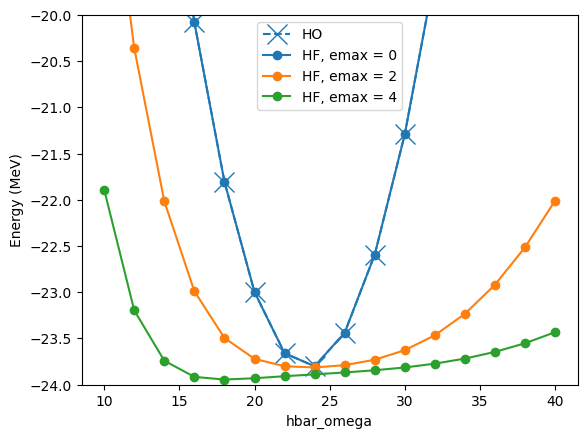

In [27]:
# Plot both HO and HF energies as a function hbar omega
colors = ["tab:blue", "tab:orange", "tab:green"]
for i in range(len(emax_vals)): # in zip(emax_vals, colors):
    color = colors[i]
    emax = emax_vals[i]
    if i == 0:
        plt.plot(hw_vals, emax_energies_ho[i], "x--", color=color, markersize=15, label="HO")
    plt.plot(hw_vals, emax_energies_hf[i], "o-", color=color, label="HF, emax = " + str(emax))
plt.legend()
plt.ylim(-24, -20)
plt.xlabel("hbar_omega")
plt.ylabel("Energy (MeV)")
plt.show()

### Problem 10: Evaluate HO and HF energies for $^{16}\mathrm{O}$. This only requires a few modifications to a few functions.

In [30]:
def generate_o16_occupation_numbers_from_basis(basis):
    '''
    Generate o16 occupation numbers from basis.

    Args:
        basis: List of HO State objects that is the single-particle basis.

    Returns:
        occupation_numbers: List of integers, where occupation_numbers[i] is 1 if basis[i] is occupied, 0 otherwise.
    '''
    
    occupation_numbers = []
    
    # TODO: Your code here
    # Can be copied and modified from 
    # generate_he4_occupation_numbers_from_basis(...)
    occupation_numbers = [0] * len(basis)
    for i, state in enumerate(basis):
        if state.n == 0 and (state.l == 0 or state.l == 1):
            occupation_numbers[i] = 1

    return occupation_numbers
    

def get_intrinsic_hamiltonian_for_o16_from_basis_and_hw(basis, hw):
    '''
    Compute the intrinsic for O16 based on your basis and hw.

    Args:
        basis: List of HO State objects that is the single-particle basis.
        hw: Integer in [10, 12, ... , 40] MeV for the oscillator frequency.

    Returns:
        h1: 1-body part of Hamiltonian with kinetic energy.
        h2: 2-body part of Hamiltonian with V_NN and 2-body kinetic energy correction.
    '''
    dim = len(basis)

    h_1b = np.zeros((dim, dim))
    h_2b = np.zeros((dim, dim, dim, dim))

    # TODO: Your code here
    # Can be copied and modified from 
    # get_intrinsic_hamiltonian_for_he_from_basis_and_hw(...)
    A = 16
    
    t = load_t(basis, hw)
    tcm_2b = load_tcm_2b(basis, hw)
    vnn = load_vnn(basis, hw)

    h_1b = (1 - 1/A) * t
    h_2b = vnn - 1/A * tcm_2b

    return h_1b, h_2b


def compute_ho_energies_o16(emax, hw_vals):
    '''
    Computes HO energies for various hw values given truncation emax.

    Args:
        emax: Basis truncation.
        hw: List of hw values.

    Returns:
        energies: List of energies corresponding to HO state expectation value at hw values.
    '''

    # TODO: Your code here
    # Can be copied and modified from
    # compute_ho_energies_o16(...)
    basis = generate_emax_basis(emax)
    occs = generate_o16_occupation_numbers_from_basis(basis)
    coeffs = np.identity(len(basis))
    rho = construct_new_density(coeffs, occs)

    energies = []
    for hw in hw_vals:
        h1, h2 = get_intrinsic_hamiltonian_for_o16_from_basis_and_hw(basis, hw)
    
        e_ho = evaluate_1and2body_energy_from_density(h1, h2, rho)

        energies.append(e_ho)

    return energies


def compute_hf_energies_o16(emax, hw_vals):
    '''
    Computes HF energies for various hw values given truncation emax.

    Args:
        emax: Basis truncation.
        hw: List of hw values.

    Returns:
        energies: List of energies corresponding to HF state expectation value at hw values.
    '''

    # TODO: Your code here
    # Can be copied and modified from
    # compute_hf_energies_he4(...)
    basis = generate_emax_basis(emax)
    occs = generate_o16_occupation_numbers_from_basis(basis)
    coeffs = np.identity(len(basis))
    rho = construct_new_density(coeffs, occs)

    energies = []
    for hw in hw_vals:
        h1, h2 = get_intrinsic_hamiltonian_for_o16_from_basis_and_hw(basis, hw)
    
        e, rho, coeffs, n_iters = solve_hartree_fock_iteratively(h1, h2, occs, verbose=False)

        energies.append(e)

    return energies



def compute_hf_coefficients_o16(emax, hw_vals):
    '''
    Computes HF energies for various hw values given truncation emax.

    Args:
        emax: Basis truncation.
        hw: List of hw values.

    Returns:
        coefficients: List of coefficent matrices corresponding to HF basis at hw values.
    '''

    # TODO: Your code here
    # Can be copied and modified from
    # compute_hf_energies_he4(...)
    basis = generate_emax_basis(emax)
    occs = generate_o16_occupation_numbers_from_basis(basis)
    coeffs = np.identity(len(basis))
    rho = construct_new_density(coeffs, occs)

    coefficients = []
    for hw in hw_vals:
        h1, h2 = get_intrinsic_hamiltonian_for_o16_from_basis_and_hw(basis, hw)
    
        e, rho, coeffs, n_iters = solve_hartree_fock_iteratively(h1, h2, occs, verbose=False)

        coefficients.append(coeffs)

    return coefficients

In [45]:
# Code to compute HF energy for various hbar omega values
emax_vals = [1, 2, 3, 4]
emax_energies_ho = []
emax_energies_hf = []
for emax in emax_vals:
    hw_vals = list(range(10, 41, 2))
    energies_ho = compute_ho_energies_o16(emax=emax, hw_vals=hw_vals)
    energies_hf = compute_hf_energies_o16(emax=emax, hw_vals=hw_vals)
    
    for hw, e_ho, e_hf in zip(hw_vals, energies_ho, energies_hf):
        print(f"hw = {hw} -> E_HO = {e_ho}")
        print(f"hw = {hw} -> E_HF = {e_hf}")

    emax_energies_ho.append(energies_ho)
    emax_energies_hf.append(energies_hf)

hw = 10 -> E_HO = -77.34557799999999
hw = 10 -> E_HF = -77.34557799999999
hw = 12 -> E_HO = -98.57728200000003
hw = 12 -> E_HF = -98.57728200000003
hw = 14 -> E_HO = -116.79188199999999
hw = 14 -> E_HF = -116.79188199999999
hw = 16 -> E_HO = -131.37163150000003
hw = 16 -> E_HF = -131.37163150000003
hw = 18 -> E_HO = -141.956838
hw = 18 -> E_HF = -141.956838
hw = 20 -> E_HO = -148.36884639999994
hw = 20 -> E_HF = -148.36884639999994
hw = 22 -> E_HO = -150.56037539999988
hw = 22 -> E_HF = -150.56037539999988
hw = 24 -> E_HO = -148.57829399999991
hw = 24 -> E_HF = -148.57829399999991
hw = 26 -> E_HO = -142.53554200000008
hw = 26 -> E_HF = -142.53554200000008
hw = 28 -> E_HO = -132.59329760000003
hw = 28 -> E_HF = -132.59329760000003
hw = 30 -> E_HO = -118.94542999999999
hw = 30 -> E_HF = -118.94542999999999
hw = 32 -> E_HO = -101.80743399999994
hw = 32 -> E_HF = -101.80743399999994
hw = 34 -> E_HO = -81.40924999999993
hw = 34 -> E_HF = -81.40924999999993
hw = 36 -> E_HO = -57.987030499999

Text(0, 0.5, 'Energy (MeV)')

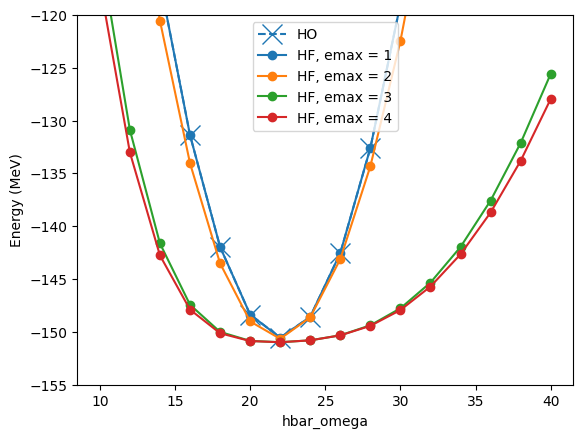

In [34]:
# Plot both HO and HF energies as a function hbar omega
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for i in range(len(emax_vals)): # in zip(emax_vals, colors):
    color = colors[i]
    emax = emax_vals[i]
    if i == 0:
        plt.plot(hw_vals, emax_energies_ho[i], "x--", color=color, markersize=15, label="HO")
    plt.plot(hw_vals, emax_energies_hf[i], "o-", color=color, label="HF, emax = " + str(emax))
plt.legend()
plt.ylim(-155, -120)
plt.xlabel("hbar_omega")
plt.ylabel("Energy (MeV)")

## Including 3N forces

The inclusion of three-body forces in our calculations is very important to get realistic results. However, three-body matrix elements are very expensive to store. Consider $V_{pqrstu}$ for a basis size of $100$. This is $10^12$ numbers, requiring $1\:\mathrm{TB}$ of storage, which is far too expensive. However, a simplification is possible if one looks carefully enough. Consider the expressions for the energy and the Fock matrix with three-body forces:

$$
\begin{aligned}
E &= \sum{pq} \rho_{pq} H_{pq} + \frac{1}{2} \sum_{pqrs} \rho_{pq} \rho_{rs} H_{prqs} + \frac{1}{6} \sum_{pqrstu} \rho_{pq} \rho_{rs} \rho_{tu} H_{prtqsu}, \\
F_{pq} &= H_{pq} + \sum_{rs} \rho_{rs} H_{prqs} + \frac{1}{2} \sum_{rstu} \rho_{rs} \rho_{tu} H_{prtqsu}.
\end{aligned}
$$

The term
$$
\sum_{tu} \rho_{tu} H_{prtqsu}
$$
is shared in both expressions. If we evaluate this, we get
$$
H_{prqs}^\mathrm{eff.} = \sum_{tu} \rho_{tu} H_{prtqsu},
$$
which looks like a two-body term. This is an effective two-body interaction to describe our three-body interaction, with the only requirement that we know the exact density to solve it. This was recently done [[Hebeler et al. Phys. Rev. C 106 (2022)](https://doi.org/10.1103/PhysRevC.106.024320)] and has helped to solve challenges with three-body forces in large calculations. The only thing to be careful of is that the prefactors for the effective two-body interactions are different from standard two-body terms:

$$
\begin{aligned}
E &= \sum{pq} \rho_{pq} H_{pq} + \frac{1}{2} \sum_{pqrs} \rho_{pq} \rho_{rs} H_{prqs} + \frac{1}{6} \sum_{pqrs} \rho_{pq} \rho_{rs} H_{prqs}^\mathrm{eff.}, \\
F_{pq} &= H_{pq} + \sum_{rs} \rho_{rs} H_{prqs} + \frac{1}{2} \sum_{rs} \rho_{rs} H_{prqs}^\mathrm{eff.}.
\end{aligned}
$$

We provide functions for you to load effective two-body matrix elements. These depend on $\hbar \omega$ (we provide $\hbar \omega = 12, 16, 20$ MeV), but also on the system of interest (for example, $^{16}\mathrm{O}$).

In [36]:
# Sample code demonstrating functions with emax=2 basis and hw=16.
basis = generate_emax_basis(emax=2)
hw = 16

# These are your helper functions
from nptlshf.helpers import load_v3n

# This function loads V_3N,pqrs^{eff.} for oxygen 16
v3n = load_v3n(basis, hw, "O16")
print(v3n.shape)

(40, 40, 40, 40)


To solve HF with three-body forces, you now have to modify how you compute the Fock matrix and the energy to account for the additional term. I have implemented these steps for you:

In [37]:
def evaluate_12and3body_energy_from_density(h1, h2, h3eff, density):
    '''
    Evaluates energy expectation value of state.

    Args:
        h1: 1-body matrix elements of Hamiltonian.
        h2: 2-body matrix elements of Hamiltonian.
        h3eff: 2-body matrix elements of effective three-body Hamiltonian.
        density: Density matrix of state.

    Returns:
        energy: Energy expectation value of state.
    '''
    energy = 0.0

    rho = density

    energy += np.einsum("ij,ij", rho, h1)
    energy += 0.5 * np.einsum("ij,kl,ikjl", rho, rho, h2)
    energy += (1/6) * np.einsum("ij,kl,ikjl", rho, rho, h3eff)

    return energy


def compute_fock_matrix_from_density_with_3body_force(h1, h2, h3eff, density):
    '''
    Computes Fock matrix from a given density.

    Args:
        h1: 1-body Hamiltonian matrix elements.
        h2: 2-body Hamiltonian matrix elements.
        h3eff: 2-body matrix elements of effective three-body Hamiltonian.
        density: 1-body density matrix.

    Returns:
        f: Fock matrix.
    '''
    f = np.zeros_like(h1)

    f = np.einsum("ikjl,kl->ij", h2, density) + h1
    f += 0.5 * np.einsum("ikjl,kl->ij", h3eff, density)

    return f

def solve_hartree_fock_iteratively_with_3n(h1, h2, h3eff, occupation_numbers, verbose=True):
    '''
    Solve the Hartree-Fock equations for a given Hamiltonian and occupation numbers.

    Args:
        h1: 1-body matrix elements of Hamiltonian.
        h2: 2-body matrix elements of Hamiltonian.
        h3eff: 2-body matrix elements of effective three-body Hamiltonian.
        occupation_numbers: List of occupation numbers.

    Returns:
        e: HF energy.
        density: HF density matrix.
        coeffs: HF basis coefficients.
        n_iters: Number of iterations required to reach convergence.
    '''
    dim = len(occupation_numbers)
    assert h1.shape == (dim, dim)
    assert h2.shape == (dim, dim, dim, dim)

    e = 0.0
    rho = np.zeros((dim, dim))
    coeffs = np.zeros((dim, dim))
    n_iters = 0

    # My solution
    max_iters = 500
    energy_convergence_criterion = 1e-4

    occs = occupation_numbers

    coeffs = np.identity(dim)
    rho = construct_new_density(coeffs, occs)
    e_prev = evaluate_12and3body_energy_from_density(h1, h2, h3eff, rho)

    for i in range(max_iters):

        f = compute_fock_matrix_from_density_with_3body_force(h1, h2, h3eff, rho)
        coeffs = diagonalize_fock_matrix(f)
        rho = construct_new_density(coeffs, occs)

        e = evaluate_12and3body_energy_from_density(h1, h2, h3eff, rho)

        if abs(e - e_prev) < energy_convergence_criterion:
            break
        else:
            if verbose:
                print(f"HF iter {n_iters}: E_{n_iters} = {e_prev} -> E_{n_iters + 1} = {e}")
            n_iters += 1
            e_prev = e
            

    return e, rho, coeffs, n_iters

### Problem 11: Solve for HO and HF energies for $^{16}\mathrm{O}$ with three-body forces included for $\hbar \omega = 12, 16, 20$. What do you find compared to your HO results?

In [39]:
def compute_ho_energies_o16_with_3n(emax, hw_vals):
    '''
    Computes HO energies for various hw values given truncation emax.

    Args:
        emax: Basis truncation.
        hw: List of hw values.

    Returns:
        energies: List of energies corresponding to HO state expectation value at hw values.
    '''

    # TODO: Your code here
    # Can be copied and modified from
    # compute_ho_energies_o16(...)
    basis = generate_emax_basis(emax)
    occs = generate_o16_occupation_numbers_from_basis(basis)
    coeffs = np.identity(len(basis))
    rho = construct_new_density(coeffs, occs)

    from nptlshf.helpers import load_v3n

    energies = []
    for hw in hw_vals:
        h1, h2 = get_intrinsic_hamiltonian_for_o16_from_basis_and_hw(basis, hw)
        h3eff = load_v3n(basis, hw, "O16")
    
        e_ho = evaluate_12and3body_energy_from_density(h1, h2, h3eff, rho)

        energies.append(e_ho)

    return energies


def compute_hf_energies_o16_with_3n(emax, hw_vals):
    '''
    Computes HF energies for various hw values given truncation emax.

    Args:
        emax: Basis truncation.
        hw: List of hw values.

    Returns:
        energies: List of energies corresponding to HF state expectation value at hw values.
    '''

    # TODO: Your code here
    # Can be copied and modified from
    # compute_hf_energies_o16(...)
    basis = generate_emax_basis(emax)
    occs = generate_o16_occupation_numbers_from_basis(basis)
    coeffs = np.identity(len(basis))
    rho = construct_new_density(coeffs, occs)

    from nptlshf.helpers import load_v3n

    energies = []
    for hw in hw_vals:
        h1, h2 = get_intrinsic_hamiltonian_for_o16_from_basis_and_hw(basis, hw)
        h3eff = load_v3n(basis, hw, "O16")
    
        e, rho, coeffs, n_iters = solve_hartree_fock_iteratively_with_3n(h1, h2, h3eff, occs, verbose=False)

        energies.append(e)

    return energies

In [43]:
def compute_ho_energies_he4_with_3n(emax, hw_vals):
    '''
    Computes HO energies for various hw values given truncation emax.

    Args:
        emax: Basis truncation.
        hw: List of hw values.

    Returns:
        energies: List of energies corresponding to HO state expectation value at hw values.
    '''

    # TODO: Your code here
    # Can be copied and modified from
    # compute_ho_energies_o16(...)
    basis = generate_emax_basis(emax)
    occs = generate_he4_occupation_numbers_from_basis(basis)
    coeffs = np.identity(len(basis))
    rho = construct_new_density(coeffs, occs)

    from nptlshf.helpers import load_v3n

    energies = []
    for hw in hw_vals:
        h1, h2 = get_intrinsic_hamiltonian_for_he4_from_basis_and_hw(basis, hw)
        h3eff = load_v3n(basis, hw, "He4")
    
        e_ho = evaluate_12and3body_energy_from_density(h1, h2, h3eff, rho)

        energies.append(e_ho)

    return energies


def compute_hf_energies_he4_with_3n(emax, hw_vals):
    '''
    Computes HF energies for various hw values given truncation emax.

    Args:
        emax: Basis truncation.
        hw: List of hw values.

    Returns:
        energies: List of energies corresponding to HF state expectation value at hw values.
    '''

    # TODO: Your code here
    # Can be copied and modified from
    # compute_hf_energies_o16(...)
    basis = generate_emax_basis(emax)
    occs = generate_he4_occupation_numbers_from_basis(basis)
    coeffs = np.identity(len(basis))
    rho = construct_new_density(coeffs, occs)

    from nptlshf.helpers import load_v3n

    energies = []
    for hw in hw_vals:
        h1, h2 = get_intrinsic_hamiltonian_for_he4_from_basis_and_hw(basis, hw)
        h3eff = load_v3n(basis, hw, "He4")
    
        e, rho, coeffs, n_iters = solve_hartree_fock_iteratively_with_3n(h1, h2, h3eff, occs, verbose=False)

        energies.append(e)

    return energies

In [44]:
emax = 4
hw_vals = [12, 16, 20]

e_ho = compute_ho_energies_he4_with_3n(emax, hw_vals)
e_hf = compute_hf_energies_he4_with_3n(emax, hw_vals)

print("He4:")
for hw, eho, ehf in zip(hw_vals, e_ho, e_hf):
    print(f"hw = {hw}, E_HO = {eho}")
    print(f"hw = {hw}, E_HF = {ehf}")

e_ho = compute_ho_energies_o16_with_3n(emax, hw_vals)
e_hf = compute_hf_energies_o16_with_3n(emax, hw_vals)

print("O16:")
for hw, eho, ehf in zip(hw_vals, e_ho, e_hf):
    print(f"hw = {hw}, E_HO = {eho}")
    print(f"hw = {hw}, E_HF = {ehf}")

He4:
hw = 12, E_HO = -14.560893666666672
hw = 12, E_HF = -22.345933016389505
hw = 16, E_HO = -19.29334366666665
hw = 16, E_HF = -23.000961566778276
hw = 20, E_HO = -22.11087266666666
hw = 20, E_HF = -22.995045687275436
O16:
hw = 12, E_HO = -75.17958200000002
hw = 12, E_HF = -88.14298840944076
hw = 16, E_HO = -89.7000195000008
hw = 16, E_HF = -89.60521412623149
hw = 20, E_HO = -86.78809906666669
hw = 20, E_HF = -88.4414472518391


**How does this compare to the energies you obtained without three-body forces?**

In [47]:
E_HF_nn_only_he4_best = -23.945719347647255
E_HF_nn_3n_he4_best   = -23.000961566778276

E_HF_nn_only_o16_best = -150.98807703466406
E_HF_nn_3n_o16_best   = -89.60521412623149

In [56]:
def get_intrinsic_hamiltonian_in_parts_for_system_from_basis_and_hw(basis, hw, system):
    '''
    Compute the intrinsic for He4 based on your basis and hw.

    Args:
        basis: List of HO State objects that is the single-particle basis.
        hw: Integer in [10, 12, ... , 40] MeV for the oscillator frequency.

    Returns:
        h1: 1-body part of Hamiltonian with kinetic energy.
        h2: 2-body part of Hamiltonian with V_NN and 2-body kinetic energy correction.
    '''
    dim = len(basis)

    h_1b = np.zeros((dim, dim))
    h_2b = np.zeros((dim, dim, dim, dim))

    # Your code here
    if system == "He4":
        A = 4
    else:
        A = 16
    
    t = load_t(basis, hw)
    tcm_2b = load_tcm_2b(basis, hw)
    vnn = load_vnn(basis, hw)
    v3n = load_v3n(basis, hw, system)

    t_1b = (1 - 1/A) * t
    t_2b = -1/A * tcm_2b

    return t_1b, t_2b, vnn, v3n

    
def compute_hf_energy_he4_with_3n_with_expectation_values(emax, hw):
    '''
    Computes HF energies for various hw values given truncation emax.

    Args:
        emax: Basis truncation.
        hw: List of hw values.

    Returns:
        energies: List of energies corresponding to HF state expectation value at hw values.
    '''

    # TODO: Your code here
    # Can be copied and modified from
    # compute_hf_energies_o16(...)
    basis = generate_emax_basis(emax)
    occs = generate_he4_occupation_numbers_from_basis(basis)
    coeffs = np.identity(len(basis))
    rho = construct_new_density(coeffs, occs)

    from nptlshf.helpers import load_v3n

    t1, t2, vnn, v3n = get_intrinsic_hamiltonian_in_parts_for_system_from_basis_and_hw(basis, hw, "He4")
    h1 = t1
    h2 = t2 + vnn

    e, rho, coeffs, n_iters = solve_hartree_fock_iteratively_with_3n(h1, h2, v3n, occs, verbose=False)

    ev_t = np.einsum("ij,ij", t1, rho) + 0.5 * np.einsum("ij,kl,ikjl", rho, rho, t2)
    ev_vnn = 0.5 * np.einsum("ij,kl,ikjl", rho, rho, vnn)
    ev_v3n = 1/6 * np.einsum("ij,kl,ikjl", rho, rho, v3n)

    print(f"E_HF  = {e}")
    print(f"<T>   = {ev_t}")
    print(f"<VNN> = {ev_vnn}")
    print(f"<V3N> = {ev_v3n}")


def compute_hf_energy_o16_with_3n_with_expectation_values(emax, hw):
    '''
    Computes HF energies for various hw values given truncation emax.

    Args:
        emax: Basis truncation.
        hw: List of hw values.

    Returns:
        energies: List of energies corresponding to HF state expectation value at hw values.
    '''

    # TODO: Your code here
    # Can be copied and modified from
    # compute_hf_energies_o16(...)
    basis = generate_emax_basis(emax)
    occs = generate_o16_occupation_numbers_from_basis(basis)
    coeffs = np.identity(len(basis))
    rho = construct_new_density(coeffs, occs)

    from nptlshf.helpers import load_v3n

    t1, t2, vnn, v3n = get_intrinsic_hamiltonian_in_parts_for_system_from_basis_and_hw(basis, hw, "O16")
    h1 = t1
    h2 = t2 + vnn

    e, rho, coeffs, n_iters = solve_hartree_fock_iteratively_with_3n(h1, h2, v3n, occs, verbose=False)

    ev_t = np.einsum("ij,ij", t1, rho) + 0.5 * np.einsum("ij,kl,ikjl", rho, rho, t2)
    ev_vnn = 0.5 * np.einsum("ij,kl,ikjl", rho, rho, vnn)
    ev_v3n = 1/6 * np.einsum("ij,kl,ikjl", rho, rho, v3n)

    print(f"E_HF  = {e}")
    print(f"<T>   = {ev_t}")
    print(f"<VNN> = {ev_vnn}")
    print(f"<V3N> = {ev_v3n}")

In [57]:
print("He4:")
print(f"emax = {2}")
compute_hf_energy_he4_with_3n_with_expectation_values(2, 16)
print(f"emax = {4}")
compute_hf_energy_he4_with_3n_with_expectation_values(4, 16)
print("O16:")
print(f"emax = {2}")
compute_hf_energy_o16_with_3n_with_expectation_values(2, 16)
print(f"emax = {4}")
compute_hf_energy_o16_with_3n_with_expectation_values(4, 16)

He4:
emax = 2
E_HF  = -22.10329584641213
<T>   = 49.42458079509005
<VNN> = -72.41433839817185
<V3N> = 0.8864617566696671
emax = 4
E_HF  = -23.000961566778276
<T>   = 51.700676604252955
<VNN> = -75.61670373999306
<V3N> = 0.9150655689618257
O16:
emax = 2
E_HF  = -89.49974599682061
<T>   = 274.651543638107
<VNN> = -405.33090649645607
<V3N> = 41.1796168615284
emax = 4
E_HF  = -89.60521412623149
<T>   = 271.0375926293272
<VNN> = -399.8580818378242
<V3N> = 39.21527508226587


## Project for future: Investigate oxygen drip line

One case that you can investigate is the drip line in neutron-rich oxygen isotopes. Typically nuclei gain binding energy by adding nucleons, but as they become neutron-rich enough, this is no longer the case, and the binding energy decreases again. In oxygen, we now know this point to be after $^{24}\mathrm{O}$. $^{24}\mathrm{O}$ is still bound, but both $^{26}\mathrm{O}$ and $^{28}\mathrm{O}$ are unbound, putting the drip line at $^{24}\mathrm{O}$.

It is an interesting exercise to compute the binding energies of $^{16}\mathrm{O}$, $^{24}\mathrm{O}$, and $^{28}\mathrm{O}$ using just two-body forces and including three-body forces. Key questions are:

- How does the inclusion of three-body forces affect the energies for these three systems?
- Do these calculations correctly identify the drip line at $^{24}\mathrm{O}$?


## Extra: Radial wave functions

We want to see how the basis is actually being optimized by the HF method. For this we will look at the radial wave functions for the states. The general 3D HO state is:

$$
\Phi_{\mathrm{HO},nlm}(\vec{r}) \sim \frac{u_{nl}(r)}{r} Y_{lm}(\hat{r}).
$$

We will focus on the radial part $u_{nl}(r)$. This has a rather complicated functional form, so a function to compute this for a given HO state is provided. See the example code below.

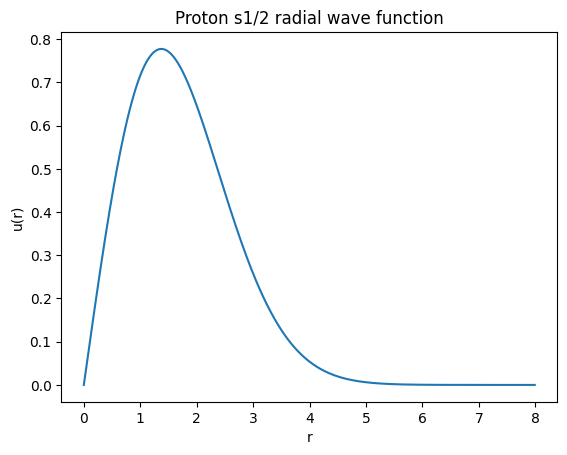

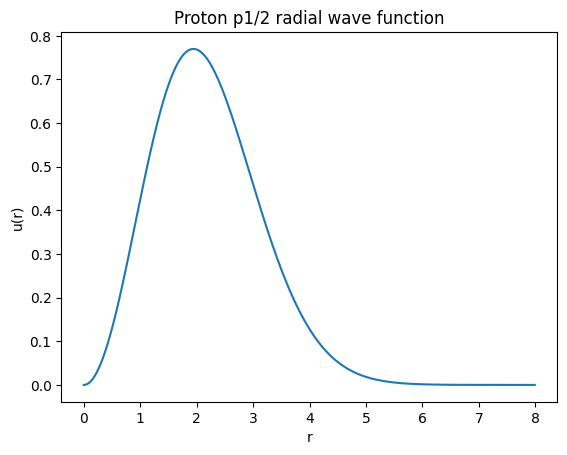

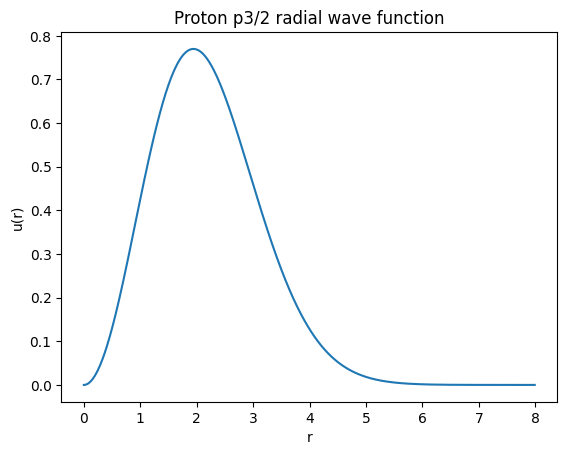

In [27]:
from nptlshf.core import State
from nptlshf.helpers import compute_radial_wavefunction

# Build states for lowest s (l = 0) and p (l = 1) orbitals.
s_orbital_proton_state = State(0, 0, 1, 1, 1)
p3_orbital_proton_state = State(0, 1, 3, 1, 1)
p1_orbital_proton_state = State(0, 1, 1, 1, 1)

# Compute their HO radial wave functions for hw=22 MeV
hw = 22
r_values = np.arange(0.0, 8.0, 0.01)
s_wf = compute_radial_wavefunction(s_orbital_proton_state, hw, r_values)
p3_wf = compute_radial_wavefunction(p3_orbital_proton_state, hw, r_values)
p1_wf = compute_radial_wavefunction(p1_orbital_proton_state, hw, r_values)

# Plot the resulting values
plt.plot(r_values, s_wf)
plt.xlabel("r")
plt.ylabel("u(r)")
plt.title("Proton s1/2 radial wave function")
plt.show()

plt.plot(r_values, p1_wf)
plt.xlabel("r")
plt.ylabel("u(r)")
plt.title("Proton p1/2 radial wave function")
plt.show()

plt.plot(r_values, p3_wf)
plt.xlabel("r")
plt.ylabel("u(r)")
plt.title("Proton p3/2 radial wave function")
plt.show()

### Problem Extra: Plot the HO and HF wave functions for an orbital of your choice for $^{16}\mathrm{O}$ for $\hbar \omega = 18, 22, 26$ MeV.

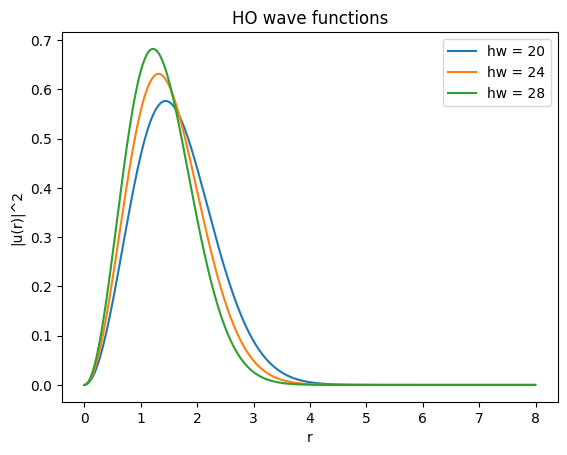

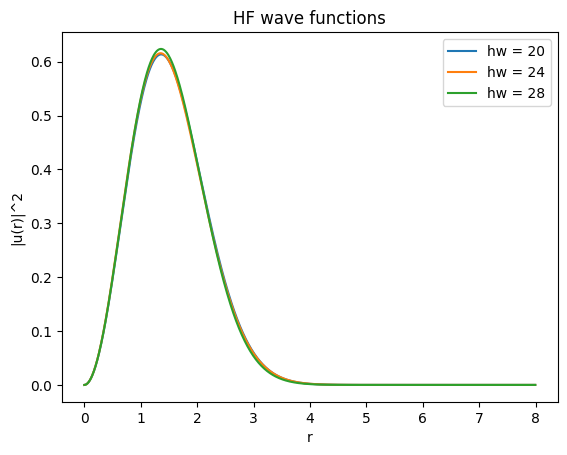

In [28]:
# Build state
my_state = State(0, 0, 1, -1, 1)

# Choose emax
emax = 3

r_values = np.arange(0.0, 8.0, 0.01)
hw_vals = [20, 24, 28]

# Compute HO wave functions and plot
for hw in hw_vals:
    my_wf = compute_radial_wavefunction(my_state, hw, r_values)
    norm_rad = sum([x**2 * 0.01 for x in my_wf])
    # print(norm_rad)
    plt.plot(r_values, my_wf**2, label="hw = " + str(hw))
plt.xlabel("r")
plt.ylabel("|u(r)|^2")
plt.title("HO wave functions")
plt.legend()
plt.show()

# Compute HF wave functions and plot
basis = generate_emax_basis(emax)
my_state_index = basis.index(my_state)
coeffs_hw = compute_hf_coefficients_o16(emax, hw_vals)
for coeffs, hw in zip(coeffs_hw, hw_vals):
    # These are the expansion coefficients for the HF state in the HO basis
    my_state_expansion_coeffs = coeffs[my_state_index]

    my_wf = np.zeros_like(r_values)
    norm = 0.0
    for c_pbar_p, state_p in zip(my_state_expansion_coeffs, basis):
        norm += c_pbar_p**2
        my_wf x+= c_pbar_p * compute_radial_wavefunction(state_p, hw, r_values)

    norm_rad = sum([x**2 * 0.01 for x in my_wf])
    # print(norm_rad)

    # Not completely clear why normalization is necessary here
    # Need to investigate further
    my_wf /= np.sqrt(norm_rad)

    # print(norm)
    plt.plot(r_values, my_wf**2, label="hw = " + str(hw))
plt.xlabel("r")
plt.ylabel("|u(r)|^2")
plt.title("HF wave functions")
plt.legend()
plt.show()